# Automated DAC Design

Inria AIO Team, April 2025

SPDX-License-Identifier: Apache License Version 2.0

<br>

**Team members**

|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
| Alfonso Cortés (Research Engineer)(**Team lead**) <br /> Email: alfonso.cortes@ieee.org | Inria (France) | Yes | Yes |
| Filip Maksimovic (Faculty) | Inria (France) | Yes |No|

## About

This notebook demonstrates a specification-to-GDS flow for Digital to Analog Converters (DACs) with the IHP SG13G2 130nm BiCMOS open PDK. The python based code is structured in different modules and stored in a different [respository](https://github.com/SDMote/Automated_DAC_Design.git) to allow updates. Future work includes adding more DAC topologies and post-layout simulation (which is currently limited by the parasitic extraction feature of the PDK), which will become available in this notebook.

In general, this work attemps to automate circuit design and physical implementation with focus on 2 aspects:
- Leveraging understanding of the circuit and the relevant solution space (i.e. the relevant range of input specifications) to estimate performance and/or define heuristics that can guide the search of a solution and reduce the computation time.
- Considering constraints from the automated layout generation in the device sizing process.

For example, the design flow for the R2R-ladder DAC topology is leveraging:
- Analytic estimation of nonlinearities for faster performance estimation. This also led to observing that there is an optimal ratio between NMOS and PMOS on-resistances in the inverters.
- Simulation of transistors on-resistances for a 2-bit DAC, which allows to avoid top-level simulation of higher resolution DACs inside of the design loop.

More details in the Thoretical background section.

<br>

## 1. Set up workspace
This section will install the tools and download the PDK and the source code.

### Install tools
The following open-source tools will be built in the `/content` directory:
- [Magic VLSI](http://opencircuitdesign.com/~tim/programs/magic/index.html), for netlist extraction
- [Netgen](http://opencircuitdesign.com/netgen/index.html), for LVS
- [Ngspice](https://ngspice.sourceforge.io/), for circuit simulation
- [OpenVAF](https://openvaf.semimod.de/), for model compilation

To generate the GDS, the [Klayout](https://www.klayout.de/) standalone Python package will be used, as it is smaller and faster to install in the notebook than the complete tool.

(This should take about 10 min)

In [ ]:
# clone and install magic
%cd /content
!git clone https://github.com/RTimothyEdwards/magic.git
%cd magic
!./configure
!make
!make install

# clone and install netgen
%cd /content
!git clone https://github.com/RTimothyEdwards/netgen
%cd netgen
!./configure
!make
!make install

# clone and compile ngspice
%cd /content
!apt install bison flex libx11-dev libx11-6 libxaw7-dev libreadline6-dev autoconf libtool automake -y
!git clone https://git.code.sf.net/p/ngspice/ngspice
!cd ngspice && ./compile_linux.sh

# install openvaf
!wget https://openva.fra1.cdn.digitaloceanspaces.com/openvaf_23_5_0_linux_amd64.tar.gz
!tar -xf openvaf_23_5_0_linux_amd64.tar.gz

# install klayout standalone python package
!pip install klayout

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 1269 |         snprintf(instname, MAX_STR_LEN-1, "%s:%s", model, inst);
      |         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
spice.c:1176:46: warning: ‘:’ directive output may be truncated writing 1 byte into a region of size between 0 and 255 [-Wformat-truncation=]
 1176 |         snprintf(instname, MAX_STR_LEN-1, "%s:%s", model, inst);
      |                                              ^
spice.c:1176:9: note: ‘snprintf’ output between 2 and 512 bytes into a destination of size 255
 1176 |         snprintf(instname, MAX_STR_LEN-1, "%s:%s", model, inst);
      |         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
spice.c:1085:44: warning: ‘:’ directive output may be truncated writing 1 byte into a region of size between 0 and 255 [-Wformat-truncation=]
 1085 |       snprintf(instname, MAX_STR_LEN-1, "%s:%s", model, inst);
      |                                            ^
spice.c:1085

In [ ]:
# execute this cell again after reseting the session
import os
PATH = os.environ['PATH']
%env PATH={PATH}:/content

env: PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content


### Download PDK and source files
The PDK respository and the project repository with the source code are cloned into the `/home` directory. Then, OpenVAF is used to compile the device models.

(This takes about 1 min)

In [ ]:
%cd /home
# clone pdk
!git clone --recursive --branch dev https://github.com/IHP-GmbH/IHP-Open-PDK.git
# clone project repo
!git clone https://github.com/SDMote/Automated_DAC_Design
# compile models
%cd /home/IHP-Open-PDK/ihp-sg13g2/libs.tech/verilog-a
!./openvaf-compile-va.sh

/home
Cloning into 'IHP-Open-PDK'...
remote: Enumerating objects: 11792, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 11792 (delta 54), reused 44 (delta 21), pack-reused 11694 (from 2)
Receiving objects: 100% (11792/11792), 364.73 MiB | 21.27 MiB/s, done.
Resolving deltas: 100% (6652/6652), done.
Updating files: 100% (4449/4449), done.
Submodule 'ihp-sg13g2/libs.tech/digital' (https://github.com/hneemann/IHP130.git) registered for path 'ihp-sg13g2/libs.tech/digital'
Submodule 'ihp-sg13g2/libs.tech/klayout/python/pycell4klayout-api' (https://github.com/IHP-GmbH/pycell4klayout-api) registered for path 'ihp-sg13g2/libs.tech/klayout/python/pycell4klayout-api'
Submodule 'ihp-sg13g2/libs.tech/klayout/python/pypreprocessor' (https://github.com/IHP-GmbH/pypreprocessor) registered for path 'ihp-sg13g2/libs.tech/klayout/python/pypreprocessor'
Cloning into '/home/IHP-Open-PDK/ihp-sg13g2/libs.tech/digital'...
remote: Enumerating

### Set paths

Finaly, it is necessary to set environment variables for the tools and also write paths in the `user.py` file for the code.



In [ ]:
%%writefile /home/Automated_DAC_Design/python/user.py
# ============================================================================

PDK = "ihp-sg13g2"
PDK_ROOT = "/home/IHP-Open-PDK"
PROJECT_ROOT = "/home/Automated_DAC_Design"

# ============================================================================


PDKPATH = PDK_ROOT + "/" + PDK
MAGICRC_PATH = PDKPATH + "/libs.tech/magic/ihp-sg13g2.magicrc"
NETGEN_SETUP = PDKPATH + "/libs.tech/netgen/ihp-sg13g2_setup.tcl"
KLAYOUT_DRC = PDKPATH + "/libs.tech/klayout/tech/drc/sg13g2_maximal.lydrc"

SIM_PATH = PROJECT_ROOT + "/python/sim"
LAYOUT_PATH = PROJECT_ROOT + "/klayout"

Overwriting /home/Automated_DAC_Design/python/user.py


In [ ]:
# execute this cell again after reseting the session
%env PDK_ROOT=/home/IHP-Open-PDK
%env PDK=ihp-sg13g2

env: PDK_ROOT=/home/IHP-Open-PDK
env: PDK=ihp-sg13g2


## 2. Design Flow

The python code should be executed from the `/home/Automated_DAC_Design/python` directory.

### Set input specifications

The main specifications for the DAC are:
- Number of bits of resolution,
- Maximum nonlinearity required, for both Integral Non-Linearity (INL) and Diferential Non-Linearity (DNL)
- Minimum output speed required, for a certain capacitance load (worst rise or fall time measured from 10% to 90% of the transition).

The different DAC topologies have topology-dependent specifications, mainly for layout. For informations about the supported topologies and their options, run `help.py`.

In [ ]:
# execute this cell again after reseting the session
%cd /home/Automated_DAC_Design/python
import matplotlib.pyplot as plt
import numpy as np
import pdk
from design.dac import help, load_specs, design_dac, simulate_dac
from layout.dac import layout_dac
help()

/home/Automated_DAC_Design/python
The design_dac function accepts user input specifications as a dictionary with the following key names:

input_specs = {'resolution':RESOLUTION, 'topology':TOPOLOGY, 'max_nl':MAX_NL, 'max_time':MAX_TIME, 'c_load':C_LOAD, 'poly_w':POLY_W, 'options':options}

where the first 6 elements corresponds to topology-independent specifications and 'options' corresponds to topology-dependent specifications.

- 'resolution':RESOLUTION	Number of bits of resolution (2-16 bits)
- 'topology':TOPOLOGY		Type of DAC circuit, 0: R2R-ladder DAC
- 'max_nl':MAX_NL		Target maximum nonlinearity (LSB), for both Integral Non-Linearity (INL) and Differential Non-Linearity (DNL)
- 'max_time':MAX_TIME		Target maximum transition time (microseconds) for the load specified in C_LOAD
- 'c_load':C_LOAD		Capacitive load (picofarad) considered for the speed of the DAC.
- 'poly_w':POLY_W		Width of the inverter input (currently not leveraged by the flow, set over PDK minimum)


The content 

In [ ]:
# general specifications
input_specs = {'resolution':10, 'topology':0, 'max_nl':0.50, 'max_time':5.0, 'c_load':50, 'poly_w':300}
# topology-dependent specifications (e.g. R2R-ladder DAC)
options = {'ideal_width':1, 'res_number':2}
input_specs['options'] = options

# alternatively edit specs.py, reset the session and run
# input_specs = load_specs()

### Circuit design

The `design_dac()` function receives the user specifications and delivers 2 dictionaries, one with circuit parameters (sizing of devices) and a larger one with all parameters relevant for layout.


In [ ]:
spice_params, layout_params = design_dac(**input_specs)


Resistance estimation:
 Ideal ratio:  0.3464189969373444
 With R= 45387.634984780394 Rn= 69.57141143710595 and Rp= 200.83024329548846
 Estimate => INL:  0.500365025876685  DNL:  0.5007064331412039  R_th= 45454.54545454545

Resistor size simulation:
 With Lr= 13.63 R= 45382.10838967466

Inverter size simulation:
 With Wn= 10.1  Wp= 9.55  and NG= 10 , then Rn= 69.19293753880237 Rp= 200.0065471751956
 Estimate => INL:  0.4984633911800529  DNL:  0.49854119637696687  R_th 45448.744559394574


### Top-level simulation

The designed circuit can be simulated to check the resulting performance metrics (nonlinearity and speed).

 Simulate => INL: 0.493992106666686  DNL: 0.4900915200000213  Worst transition time: 4.990565e-06
Worst transition time:  4.990565e-06  us


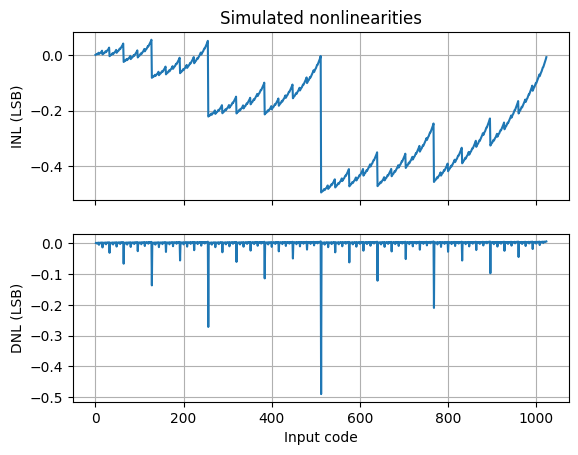

In [ ]:
inl, dnl, rise_time = simulate_dac(input_specs['topology'], spice_params, input_specs['c_load'])

# Plot nonlinearities
Q = 2**input_specs['resolution']
lsb = pdk.LOW_VOLTAGE/Q
digital_input = np.arange(Q)

print("Worst transition time: ", rise_time, " us")

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(digital_input, inl, label='estimated inl')
axs[0].set_ylabel("INL (LSB)")
axs[0].grid()
axs[1].plot(digital_input[1:], dnl, label='estimated dnl')
axs[1].set_ylabel("DNL (LSB)")
axs[1].set_xlabel("Input code")
axs[1].grid()
axs[0].set_title("Simulated nonlinearities")
plt.show()

### Layout generation

Finally, the layout of the DAC is automatically generated. The KLayout standalone python package is enough to generate GDS files and access the Pcell generator of the PDK.

In [ ]:
layout_dac(input_specs['topology'], layout_params)

 Writing inverter GDS
 Writing R-2R GDS
 Writing 2R-2R GDS
 Writing RDAC GDS

Verification:
 Running LVS


The LVS result is in `/home/Automated_DAC_Design/netgen/comp.out`.

The GDS can be opened with a local installation of Magic or KLayout (not from within the notebook). The produced GDS is DRC free, except for density rules that require adding fillers. This can be verified by opening the layout with Magic or by running the following command with a local installation of KLayout:

```
klayout -zz -r /home/IHP-Open-PDK/libs.tech/klayout/tech/drc/sg13g2_maximal.lydrc -rd in_gds="../klayout/dac.gds" -rd report_file="../klayout/drc/sg13g2_maximal.lyrdb"
```

This verification is included when running the source code localy.

<br>

## 3. Theoretical background

At the time of the submission, this work only supports the complete design flow for the R2R-ladder DAC topology.

### R2R-ladder DAC

The R2R-ladder DAC, as shown in the figure, is made of inverters (one for each resolution bit) that are connected to a ladder of resistors, which have a unit resistance (R) or twice the unit resistance (2R). It can be shown that, by supperposition, each bit $i$ of an **ideal** N-bit R2R DAC produces $v_i=V_{REF}\cdot\frac{2^i}{2^N}$ in the output.

![R2R Circuit](https://raw.githubusercontent.com/SDMote/Automated_DAC_Design/main/background/resistor_ladder_dac.png)

However, to produce the desired output perfectly, the R-2R ratio in the ladder must be precise, making this circuit very sensitive to parasitic resistances, particularly the on-resistances of the inverter transistors.
Then, the main design parameters for the circuit are the sizing of the unit resistor and the transistors in the inverter, that is, width and lenght for 3 devices: NMOS, PMOS and resistor.

In general, we need the on-resistances of the transistors to be negligible compared to the unit resistance R. Resistor width and transistor lenght are fixed for convenience. Then, increasing the resistor lenght is an easy solution but it comes at the expense of reducing the circuit speed. It will also be necessary to increase the transistors width to reduce their on-resistances. Increasing the area of the pysical implementation with both of this actions will increase the parasitic resistance of the routing between devices.



#### Nonlinearity estimation

Under the assumption that the on-resistances of the transistors are constant over input codes and bits, the voltage output of the DAC can be calculated recursively taking the on-resistances into consideration, as shown in the following figure. This allows to estimate the nonlinearity of the circuit much faster than with simulation.

![Output calculation](https://raw.githubusercontent.com/SDMote/Automated_DAC_Design/main/background/r2r_dac.png)

Simulation of the top-level circuit showed that the transistors on-resistance behaves constant over input codes and bits if they are sufficiently small compared to the unit resistance. This is usually true in the relevant solution space. Moreover, under the same conditions, it can be observed that the value of the on-resistances varies very little when changing the resolution of the DAC. This was leveraged in the circuit design step, where on-resistance estimation is always done by simulating a 2-bit DAC and top-level performance is estimated analyticaly as explained above. Since the spice simulation time increases exponentially with the number of bits, this method reduces computation time significantly. The results show that the presented R2R-ladder DAC design loop can effectively reach the target performance without simulating the top-level circuit.



### Other topologies

Future additions to the project will be available within the notebooks flow, but the corresponding theoretical details will only appear in the source code [repository](https://github.com/SDMote/Automated_DAC_Design.git).

